# Annual Sea Level Rankings

```{glue:figure} SL_rankings
:scale: 80%
:align: center
```
In this notebook, we'll be creating a [table](SL_rankings_results), a [map](SL_rankings_map), and a time series [plot](SL_rankings_timeseries) of sea level rankings at Hawaiian Islands tide gauge stations from 1993-2023. 

Download Files:
[Map](../../output/SL_rankings_map.png) |
[Time Series Plot](../../output/SL_rankings_Kahului.png) |
[Table](../../output/SL_top_10_table_Kahului.csv)

## Setup

As with previous sections, we first need to import the necessary libraries, establish our input/output directories, and set up some basic plotting rules. We'll do this by running another notebook called "setup" and "plotting functions," and then we'll set our data and output paths. If you have not run the datawrangling notebook, you will need to do this before running this notebook. Note that this notebook is also largely a repeat of the anomaly notebook. 

```{margin}
```{note}
**TODO**
- Confirm numbers match
- Figure captions
- Figure labels
- Text
- Clean up code
- add commentary
```

In [49]:
%run ../setup.ipynb
%run ../plotting_functions.ipynb

# We're going to use plotly here, so we need to import it
import plotly.io as pio
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go

# check to make sure that data_dir/rsl_daily_hawaii.nc exists, if not, make warning to run datawrangling notebook
if not (data_dir / 'rsl_pacific.nc').exists():
    print('rsl_hawaii.nc not found in '+ str(data_dir) +  '. Please run the data wrangling notebook first')
else:
    print('rsl_hawaii.nc found in '+ str(data_dir) +  '. Proceed.')

rsl_hawaii.nc found in /Users/jfiedler/Documents/SL_Hawaii_data/data. Proceed.


### Import data and Clean
Take only locations with data coverage more than 80% of the time, and set all sea level measurements relative to local MHHW, rather than station datum.

In [50]:
#import rsl_daily
with xr.open_dataset(data_dir/ 'rsl_pacific.nc') as ds:
    rsl_daily = ds.sel(time=slice('1993','2024'))

    data_coverage = rsl_daily['sea_level'].count(dim='time')/len(rsl_daily.time)

    data_coverage
    #drop all locations with data_coverage less than 80%
    rsl_subset = rsl_daily.where(data_coverage>0.80,drop=True)

# make sea level relative to MHHW, and convert to m
rsl_subset['sea_level'] = rsl_subset['sea_level'] - rsl_subset['MHHW']
rsl_subset['sea_level'] = rsl_subset['sea_level']/1000

# rename variable long name to sea level relative to MHHW
rsl_subset['sea_level'].attrs['long_name'] = 'sea level, MHHW'
rsl_subset['sea_level'].attrs['units'] = 'm'

### Resample to monthly
For background plotting purposes. Here we'll extract the mean, min and max of the monthly MHHW sea level.

In [51]:
# get min and max for each month by resampling
rsl_monthly_min = rsl_subset.resample(time='1ME').min()
rsl_monthly_max = rsl_subset.resample(time='1ME').max()
rsl_monthly_mean = rsl_subset.resample(time='1ME').mean()

### Define functions
The first will get us the top 10 high and low hourly sea level values for a given station. To ensure that we are tracking unique high and low water events, we ensure that the hourly maxima and minima are separated by at least 3 days.

In [64]:
def get_top_ten(rsl_subset, rid, mode='max'):
    # Convert data to a pandas Series
    sea_level_series = rsl_subset.sea_level.isel(record_id=rid).to_series()


   # Select top 100 values based on the mode
    if mode == 'max':
        top_values = sea_level_series.nlargest(100)
    elif mode == 'min':
        top_values = sea_level_series.nsmallest(100)
    else:
        raise ValueError('mode must be either "max" or "min"')

    # Filter to find unique events spaced by at least 3 days
    filtered_dates = []
    top_10_values = pd.Series()

    for date, value in top_values.items():
        if all(abs((date - pd.to_datetime(added_date)).days) > 3 for added_date in filtered_dates):
            filtered_dates.append(date)
            top_10_values[date] = value
        if len(filtered_dates) == 20:
            break
    rank = np.arange(1,21)

    station_name = str(rsl_subset['station_name'].isel(record_id=rid).values)
    record_id = str(rsl_subset['record_id'].isel(record_id=rid).values)  

    top_10_values = pd.DataFrame({'rank': rank, 'date': top_10_values.index, 'sea level (m)': top_10_values.values})  
    top_10_values['station_name'] = station_name
    top_10_values['record_id'] = record_id
    top_10_values['type'] = mode

    #round the date to the nearest hour
    top_10_values['date'] = top_10_values['date'].dt.round('h')

    return top_10_values

## Make a Table
We'll use the function we defined above to make a table of the top 10 ranked high and low water events. We'll add the ONI values to this table, which will come in handy later.

In [53]:
def get_top_10_table(rsl_subset,rid):
    # make a table of the top 10 values, sorted by size and with date
    top_10_values_max = get_top_ten(rsl_subset, rid, mode='max')
    top_10_values_min = get_top_ten(rsl_subset, rid, mode='min')

    top_10_table = pd.concat([top_10_values_max,top_10_values_min])

    # cross reference the dates with the oni data to see if they are during an El Nino or La Nina event
    oni = pd.read_csv(data_dir / 'climate_indices' / 'oni.csv', index_col='time', parse_dates=True)

    # El Nino is true when ONI > 0.5 for 5 consecutive periods 
    oni['El Nino'] = (oni['ONI'] > 0.5).rolling(window=5).sum() == 5

    # La Nina is true when ONI < -0.5 for 5 consecutive periods 
    oni['La Nina'] = (oni['ONI'] < -0.5).rolling(window=5).sum() == 5

    # add a new column to oni_min called mode, where mode is either 'El Nino', 'La Nina', or 'Neutral'
    oni['ONI Mode'] = 'Neutral'
    oni.loc[oni['La Nina'] ==True, 'ONI Mode'] = 'La Nina'
    oni.loc[oni['El Nino'] ==True, 'ONI Mode'] = 'El Nino'

    #drop the La Nina and El Nino columns
    oni = oni.drop(columns=['La Nina', 'El Nino'])

    #Extract ONI values for the corresponding dates of top_10_table
    oni_val = oni.reindex(top_10_table['date'], method='nearest')
    
    # add the oni values to the top_10_table
    top_10_table = pd.merge(top_10_table, oni_val, left_on='date', right_index=True)

    return top_10_table


As a quick example, we can check the top of the table (the "head") for the 4th record_id, which is Kahului, Maui.

In [67]:
a = get_top_ten(rsl_subset, 1, mode='max')
a

,rank,date,sea level (m),station_name,record_id,type
0,1,2020-04-08 19:00:00,0.902,Nuku'alofa,38,max
1,2,2014-03-01 06:00:00,0.588,Nuku'alofa,38,max
2,3,2022-01-03 07:00:00,0.566,Nuku'alofa,38,max
3,4,2010-02-15 08:00:00,0.538,Nuku'alofa,38,max
4,5,2009-01-11 06:00:00,0.507,Nuku'alofa,38,max
5,6,2020-10-17 07:00:00,0.506,Nuku'alofa,38,max
6,7,2020-12-15 07:00:00,0.493,Nuku'alofa,38,max
7,8,2023-02-21 07:00:00,0.488,Nuku'alofa,38,max
8,9,2022-12-26 09:00:00,0.482,Nuku'alofa,38,max
9,10,2012-02-14 00:00:00,0.480,Nuku'alofa,38,max


In [59]:
rsl_subset

<xarray.Dataset> Size: 7MB
Dimensions:               (record_id: 2, time: 280512)
Coordinates:
  * time                  (time) datetime64[ns] 2MB 1993-01-01 ... 2024-12-31...
  * record_id             (record_id) int64 16B 25 38
Data variables: (12/13)
    sea_level             (record_id, time) float64 4MB nan nan ... -0.579
    lat                   (record_id) float32 8B -8.525 -21.13
    lon                   (record_id) float32 8B 179.2 184.8
    station_name          (record_id) object 16B 'Funafuti' "Nuku'alofa"
    station_country       (record_id) object 16B 'Tuvalu' 'Tonga'
    station_country_code  (record_id) float32 8B 798.0 776.0
    ...                    ...
    gloss_id              (record_id) float32 8B 121.0 125.0
    ssc_id                (record_id) object 16B 'fong' 'nkfa'
    last_rq_date          (record_id) datetime64[ns] 16B 2021-12-31T22:59:59....
    MHHW                  (record_id) float64 16B 2.743e+03 1.525e+03
    MSL                   (record_id) float64 16B 2.05e+03 952.0
    MLLW                  (record_id) float64 16B 1.388e+03 368.0
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2025-03-17T14:43:54Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

In [54]:
rid=1
top_10_table = get_top_10_table(rsl_subset,rid)
top_10_table

ValueError: All arrays must be of the same length

### Display by rank
Now we'll start to make the table a little more presentable by labeling the columns properly, and organizing events by rank.

In [21]:
# subdivide the data into two columns for max and min
# Filter out the 'max' and 'min' types into separate DataFrames
max_top_10 = top_10_table[top_10_table['type'] == 'max'].reset_index(drop=True)
min_top_10 = top_10_table[top_10_table['type'] == 'min'].reset_index(drop=True)

# make table of highest and lowest values by rank, with columns: rank, highest sea level (m), date, lowest sea level (m), date
top_10_display = pd.DataFrame({'Rank':max_top_10['rank'],
                             'Highest':max_top_10['sea level (m)'],
                             'Highest Date':max_top_10['date'].dt.strftime('%Y-%m-%d %H:%M'),
                             'Highest ONI Mode':max_top_10['ONI Mode'],
                             'Lowest':min_top_10['sea level (m)'],
                             'Lowest Date':min_top_10['date'].dt.strftime('%Y-%m-%d %H:%M'),
                             'Lowest ONI Mode':min_top_10['ONI Mode'],
                             'Zone': 'GMT',
                             'ONI max':max_top_10['ONI'],
                             'ONI min':min_top_10['ONI']})

top_10_display

,Rank,Highest,Highest Date,Highest ONI Mode,Lowest,Lowest Date,Lowest ONI Mode,Zone,ONI max,ONI min
0,1,0.902,2020-04-08 19:00,Neutral,-1.565,1995-06-14 01:00,Neutral,GMT,0.19,-0.03
1,2,0.588,2014-03-01 06:00,Neutral,-1.545,1994-06-24 01:00,Neutral,GMT,-0.27,0.44
2,3,0.566,2022-01-03 07:00,La Nina,-1.545,1995-05-16 02:00,Neutral,GMT,-0.97,0.14
3,4,0.538,2010-02-15 08:00,El Nino,-1.535,1995-12-23 14:00,La Nina,GMT,0.84,-0.90
4,5,0.507,2009-01-11 06:00,Neutral,-1.515,1993-10-16 13:00,Neutral,GMT,-0.85,0.04
5,6,0.506,2020-10-17 07:00,Neutral,-1.515,1994-04-27 02:00,Neutral,GMT,-1.27,0.42
6,7,0.493,2020-12-15 07:00,La Nina,-1.515,1994-11-05 14:00,Neutral,GMT,-1.19,1.01
7,8,0.488,2023-02-21 07:00,Neutral,-1.505,1993-07-21 02:00,Neutral,GMT,-0.15,0.25
8,9,0.482,2022-12-26 09:00,La Nina,-1.505,1993-11-15 14:00,Neutral,GMT,-0.68,0.04
9,10,0.480,2012-02-14 00:00,La Nina,-1.505,1994-07-23 01:00,Neutral,GMT,-0.72,0.43


(SL_rankings_results)=
### Style the table
Now we'll add some style. The table will be colored by the ONI, if the event is classified as an El Nino or La Nina.

In [22]:
# # Define a function that returns styles for both 'Highest' and 'Lowest' based on respective ONI Modes
# # Normalize the ONI values
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=-3, vmax=3)

# Define the color maps
cmap = sns.color_palette('coolwarm', as_cmap=True)

def style_oni_based(row):
    styles = {}
    # Color for 'Highest' based on 'Highest ONI Mode'
    if row['Highest ONI Mode'] == 'El Nino':
        styles['Highest'] = f'background-color: {mcolors.rgb2hex(cmap(norm(row["ONI max"])))}'
    elif row['Highest ONI Mode'] == 'La Nina':
        styles['Highest'] = f'background-color: {mcolors.rgb2hex(cmap(norm(row["ONI min"])))}'
    else:
        styles['Highest'] = 'color: black'  # Neutral or undefined
    # Color for 'Lowest' based on 'Lowest ONI Mode'
    if row['Lowest ONI Mode'] == 'El Nino':
        styles['Lowest'] = f'background-color: {mcolors.rgb2hex(cmap(norm(row["ONI max"])))}'
    elif row['Lowest ONI Mode'] == 'La Nina':
        styles['Lowest'] = f'background-color: {mcolors.rgb2hex(cmap(norm(row["ONI min"])))}'
    else:
        styles['Lowest'] = 'color: black'  # Neutral or undefined
    return pd.Series(styles)    

# Define the table style
styles_col = [
    {'selector': 'th', 'props': [('border-bottom', '2px solid #000'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': '.dataframe th:nth-child(3)', 'props': [('padding-right', '100px')]}]

# Apply the styling function to the DataFrame
top_10_d = top_10_display.style.\
                            apply(style_oni_based, axis=1).\
                            hide(subset=['Highest ONI Mode', 'Lowest ONI Mode','ONI max','ONI min'], axis=1).\
                            hide().\
                            set_table_attributes(styles_col)


# Display the styled DataFrame

station_name = str(rsl_subset['station_name'].isel(record_id=rid).values)


tablename = 'SL_top_10_table_' + station_name + '.csv'
# save table to output folder
top_10_display.to_csv(output_dir / tablename, index=False)

top_10_d

Rank,Highest,Highest Date,Lowest,Lowest Date,Zone
1,0.902000,2020-04-08 19:00,-1.565000,1995-06-14 01:00,GMT
2,0.588000,2014-03-01 06:00,-1.545000,1994-06-24 01:00,GMT
3,0.566000,2022-01-03 07:00,-1.545000,1995-05-16 02:00,GMT
4,0.538000,2010-02-15 08:00,-1.535000,1995-12-23 14:00,GMT
5,0.507000,2009-01-11 06:00,-1.515000,1993-10-16 13:00,GMT
6,0.506000,2020-10-17 07:00,-1.515000,1994-04-27 02:00,GMT
7,0.493000,2020-12-15 07:00,-1.515000,1994-11-05 14:00,GMT
8,0.488000,2023-02-21 07:00,-1.505000,1993-07-21 02:00,GMT
9,0.482000,2022-12-26 09:00,-1.505000,1993-11-15 14:00,GMT
10,0.480000,2012-02-14 00:00,-1.505000,1994-07-23 01:00,GMT


In [23]:
#make this a pretty table with great_tables
from great_tables import GT, md, html

# replace all spaces with underscores in top_10_display column names
top_10_display.columns = top_10_display.columns.str.replace(' ', '_')

# Convert the DataFrame to a great_table
(
    GT(top_10_display)
    .tab_header(title='Top 10 Sea Level Events', subtitle='Station: '+station_name)
    .tab_spanner(label='HIGHEST', columns=['Highest', 'Highest_Date', 'Highest_ONI_Mode'])
    .tab_spanner(label='LOWEST', columns=['Lowest', 'Lowest_Date', 'Lowest_ONI_Mode'])
    .cols_hide(columns=['ONI_max','ONI_min','Zone'])
    .cols_align('center')
    .cols_label(Highest=html('Water Level <br>(m, MHHW)'), Highest_Date='Date', Highest_ONI_Mode='ONI Mode',
                Lowest=html('Water Level <br>(m, MHHW)'), Lowest_Date='Date', Lowest_ONI_Mode='ONI Mode')
                .tab_source_note(source_note='Source: UHSLC RQDS, https://psl.noaa.gov/data/correlation/oni.data')
    .save('..output/top_10_table.png')
)

(SL_rankings_timeseries)=
## Make Timeseries Plots
Now we'll plot this data up in the time domain.

### Interactive Plots
This version is interactive. Bad for making pdf reports though.

In [40]:
import plotly.graph_objects as go
import numpy as np

def split_data(x,y):
    # split the data into segments when there are gaps
    mask = ~np.isnan(y)
    df = pd.DataFrame({'x':x, 'y':y, 'mask':mask})

    # Assign group IDs to contiguous non-NaN segments
    df["group"] = (df["mask"] != df["mask"].shift()).cumsum()
    
    segments = []
    for _, group in df.groupby("group"):
        if group["mask"].iloc[0]:  # Only keep segments where mask is True
            segments.append((group["x"].values, group["y"].values))
    
    return segments



def make_plotlyFigure(rsl_monthly_mean, rsl_monthly_max, rsl_monthly_min, top_10_table, rsl_subset, rid):
    figly = go.Figure()
    top_10_table = get_top_10_table(rsl_subset, rid)
    x = rsl_monthly_mean.time - np.timedelta64(15, 'D')  # add 15 days to make the line in the middle of the month
    
    # deal with data gaps:
    max_segments = split_data(x, rsl_monthly_max['sea_level'].isel(record_id=rid).values)
    min_values = rsl_monthly_min['sea_level'].isel(record_id=rid).values


    # Add traces
    first_trace = True
    for (x_seg, y_seg) in max_segments:
        y_seg_min = min_values[np.isin(x, x_seg)]
        figly.add_trace(go.Scatter
                        (x=x_seg, y=y_seg, mode='lines', 
                         line_color='rgba(0,176,246,0.2)', 
                         name='Monthly Max' if first_trace else None,
                         showlegend=first_trace))
        figly.add_trace(go.Scatter
                        (x=x_seg, y=y_seg_min, mode='lines', 
                         line_color='rgba(0,176,246,0.2)', 
                         fill='tonexty', fillcolor='rgba(0,176,246,0.2)', 
                         name='Range (Monthly Max/Min)'if first_trace else None,
                         showlegend=first_trace))
        first_trace = False

    # add monthly mean
    figly.add_trace(go.Scatter(x=x, y=rsl_monthly_mean['sea_level'].isel(record_id=rid), mode='lines', line_color='rgba(0,176,246,1)', name='Monthly Mean'))
    
    # Add El Niño markers
    figly.add_trace(go.Scatter(x=top_10_table[top_10_table['ONI Mode']=='El Nino'].date,
                                y=top_10_table[top_10_table['ONI Mode']=='El Nino']['sea level (m)'],
                                mode='markers', marker=dict(color='red', size=12, symbol='star'), name='El Niño',
                                hoverinfo='none'))
    
    # Add La Niña markers
    figly.add_trace(go.Scatter(x=top_10_table[top_10_table['ONI Mode']=='La Nina'].date,
                                y=top_10_table[top_10_table['ONI Mode']=='La Nina']['sea level (m)'],
                                mode='markers', marker=dict(color='blue', size=12, symbol='circle'), name='La Niña',
                                hoverinfo='none'))
    
    # Add highest/lowest events markers
    figly.add_trace(go.Scatter(x=top_10_table.date, y=top_10_table['sea level (m)'], 
                                mode='markers', marker=dict(color='orange', size=6, symbol='circle'), name='Highest/Lowest Events',
                                hovertemplate='%{x}, %{y:.2f} m<extra></extra>'))
    
    # Update layout
    figly.update_layout(
        title=str(rsl_subset['station_name'].isel(record_id=rid).values),
        xaxis_title='Time',
        yaxis_title=f"{rsl_subset['sea_level'].attrs['long_name']} [{rsl_subset['sea_level'].attrs['units']}]",
        showlegend=True,
        # width=500,  # Set figure width
        # height=400,  # Set figure height
        autosize=True,  # Turn off autosize
        plot_bgcolor='white',
        xaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='rgb(200,200,200)', range=['1993-01-01', '2024-12-31']),
        yaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='rgb(200,200,200)'),
        legend=dict(
            orientation='h',  # Horizontal orientation
            y=-0.3,  # Position below the plot
            x=0.5,  # Centered horizontally
            xanchor='center',
            yanchor='top',
            font=dict(size=10)  # Smaller font size for legend items
        ),
        margin=dict(l=50, r=50, t=50, b=100),  # Increase bottom margin to make room for the legend
        title_x=0.5,  # Center the title
        title_font_size=20,
        title_font_family='Arial',
        title_font_color='black'
    )


    
    # figly.show()
    return figly

In [42]:
figly = make_plotlyFigure(rsl_monthly_mean, 
        rsl_monthly_max, rsl_monthly_min, 
        top_10_table, rsl_subset,1)

# change size of the plot
# figly.update_layout(autosize=True)
figly.update_layout(width=800, height=500,autosize=False)
station_name = str(rsl_subset['station_name'].isel(record_id=1).values)
# save the figure to the output folder
figname = 'SL_top_10_plot_' + station_name + '.html'

# remove commas from figname
figname = figname.replace(', ','_')
matrix_dir = Path('../../matrix/plotly')
pio.write_html(figly, str(matrix_dir / figname), auto_open=False)

figly.show()

### Static Plots
Plotting them all so we can decide what to do with them. Click "show code cell output" to see all stations.

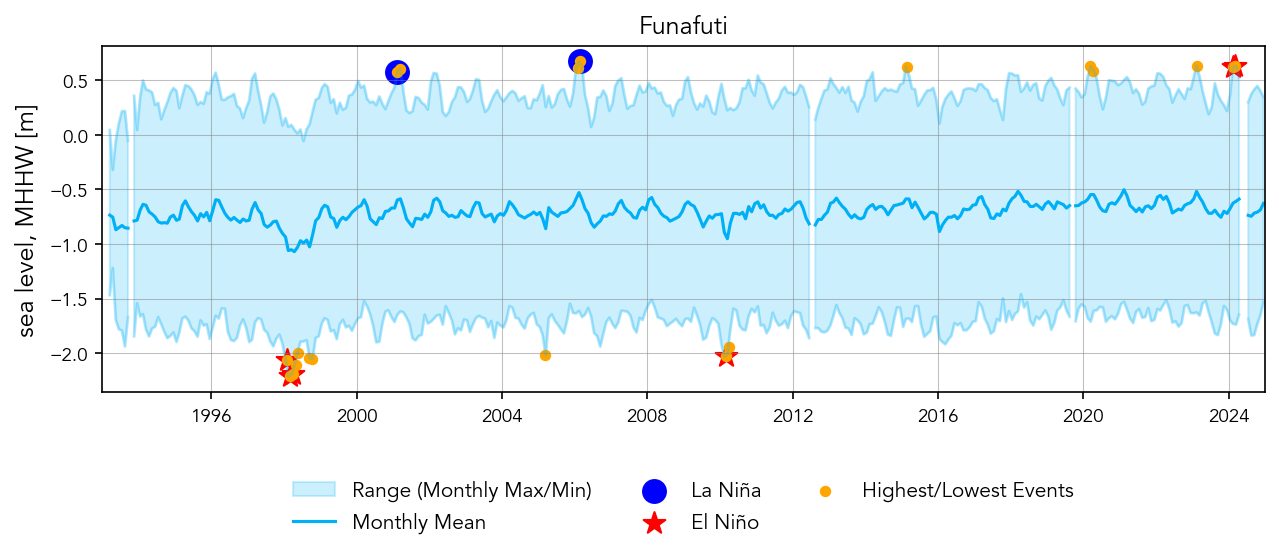

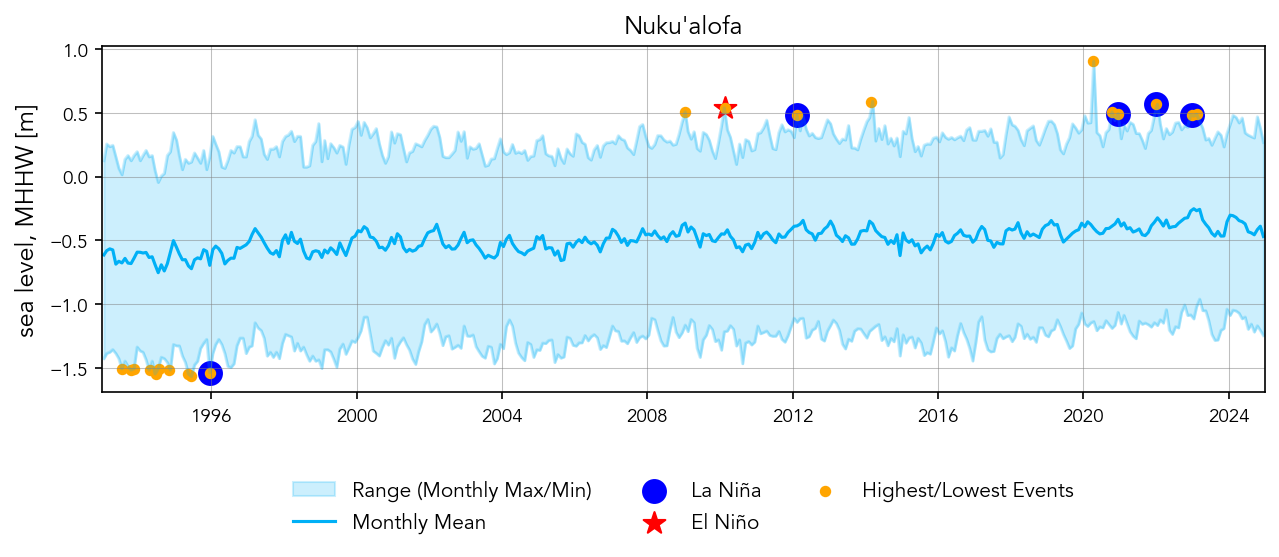

In [26]:
# static version

# Plot configuration

# loop through all the records
for i in range(len(rsl_subset.record_id)):
    rid = i
    top_10_table = get_top_10_table(rsl_subset,rid)
    # get top_10_table for each record

    fig,ax = plt.subplots(1,1,figsize=(10,3))

    x = rsl_monthly_mean.time - np.timedelta64(15,'D') # add 15 days to make the line in the middle of the month
    
    station_name = str(rsl_subset['station_name'].isel(record_id=rid).values)
    ax.set_title(station_name)
    ax.set_ylabel(f'{rsl_subset["sea_level"].attrs["long_name"]} [{rsl_subset["sea_level"].attrs["units"]}]')
    
    # Plot the max, min, and mean lines
    # Plot the max, min, and mean lines
    ax.plot(x, rsl_monthly_max['sea_level'].isel(record_id=rid), color=(0/255, 176/255, 246/255, 0.2))
    ax.plot(x, rsl_monthly_min['sea_level'].isel(record_id=rid), color=(0/255, 176/255, 246/255, 0.2))
    ax.fill_between(x, rsl_monthly_max['sea_level'].isel(record_id=rid), 
                     rsl_monthly_min['sea_level'].isel(record_id=rid), color=(0/255, 176/255, 246/255, 0.2), label='Range (Monthly Max/Min)')
    ax.plot(x, rsl_monthly_mean['sea_level'].isel(record_id=rid), color=(0/255, 176/255, 246/255, 1), label='Monthly Mean')
    
    # Plot the markers for La Niña, El Niño, and other events
    ax.scatter(top_10_table[top_10_table['ONI Mode']=='La Nina'].date, top_10_table[top_10_table['ONI Mode']=='La Nina']['sea level (m)'], color='blue', s=120, label='La Niña', marker='o')
    ax.scatter(top_10_table[top_10_table['ONI Mode']=='El Nino'].date, top_10_table[top_10_table['ONI Mode']=='El Nino']['sea level (m)'], color='red', s=120, label='El Niño', marker='*')
    ax.scatter(top_10_table.date, top_10_table['sea level (m)'], color='orange', s=20, label='Highest/Lowest Events', marker='o')
    
    # Setting the x-axis limits
    ax.set_xlim(pd.Timestamp('1993-01-01'), pd.Timestamp('2024-12-31'))
    
    # Improve the appearance
    ax.grid(True, color='gray', alpha=0.5 ,linewidth=0.5)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, frameon=False, fontsize=10)
    
    
    # Save the plot to a file
    figname = 'SL_rankings_' + str(rsl_subset['station_name'].isel(record_id=rid).values) + '.png'
    fig.savefig(output_dir / figname, dpi=300, bbox_inches='tight')


glue("SL_rankings",fig,display=False)

```{glue:figure} SL_rankings
:name: "SL_rankings"

This is a static version of the previous figure. I am using this static version because there is more control over the printed figure.
```

(SL_rankings_map)= 
## Create a map
Now we'll make a map of this information, using max and min at each station. First we need to organize our data.

In [135]:
# concatenate the top 10 values for each record
top_10_table_all = pd.concat([get_top_10_table(rsl_subset,rid) for rid in range(len(rsl_subset.record_id))])


# max_SL is all rank 1, with type max
max_SL = top_10_table_all[top_10_table_all['rank'] == 1 & (top_10_table_all['type'] == 'max')].copy()

# sort by record_id
max_SL = max_SL.sort_values('record_id')
rsl_subset = rsl_subset.sortby('record_id')

max_SL.loc[:, 'lat'] = rsl_subset['lat'].values
max_SL.loc[:, 'lon'] = rsl_subset['lon'].values



# min SL is all rank 1, with type min
min_SL = top_10_table_all[top_10_table_all['rank'] == 1 & (top_10_table_all['type'] == 'min')].copy()

# sort by record_id
min_SL = min_SL.sort_values('record_id')

min_SL.loc[:, 'lat'] = rsl_subset['lat'].values
min_SL.loc[:, 'lon'] = rsl_subset['lon'].values

Next, we'll plot it up.

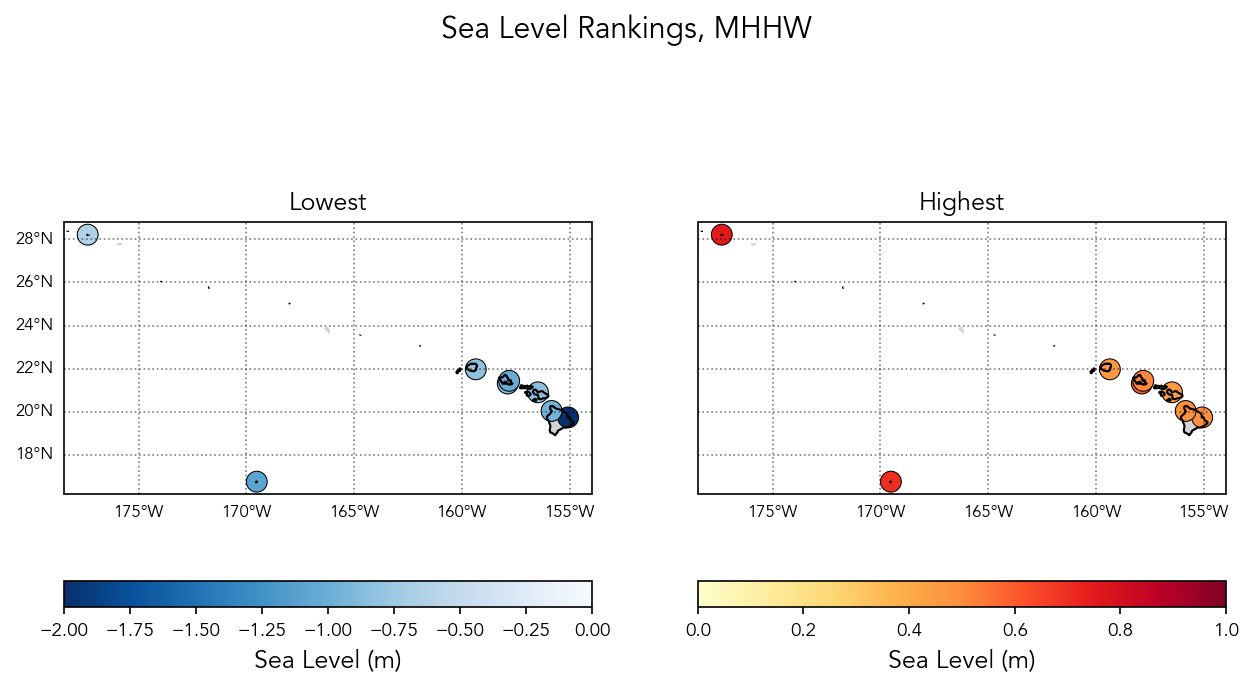

In [136]:
# define vmin and vmax variables
vmin = 0.2
vmax = 0.8

# open the cmems data
cmems = xr.open_dataset(data_dir / 'cmems_L4_SSH_0.125deg_1993_2024.nc')

xlims = [cmems.longitude.min(), cmems.longitude.max()]
ylims = [cmems.latitude.min(), cmems.latitude.max()]

# get max value for each station
crs = ccrs.PlateCarree()

fig, axs = plt.subplots(1,2,figsize=(10, 5), subplot_kw={'projection': crs})
# make ax,fig


maxplt = axs[1].scatter(max_SL['lon'], max_SL['lat'], transform=crs, s=100, 
           c=max_SL['sea level (m)'], vmin=0, vmax=1, cmap='YlOrRd',
           linewidth=0.5, edgecolor='black')

minplt = axs[0].scatter(min_SL['lon'], min_SL['lat'], transform=crs, s=100, 
           c=min_SL['sea level (m)'], vmin=-2, vmax=0, cmap='Blues_r',
           linewidth=0.5, edgecolor='black')

plt.colorbar(minplt,ax=axs[0],label='Sea Level (m)', location='bottom')           
plt.colorbar(maxplt,ax=axs[1],label='Sea Level (m)', location='bottom') 


for i, ax in enumerate(axs.flat):
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, color='lightgrey')

    #add grid
    gl = ax.gridlines(draw_labels=False, linestyle=':', color='black',
                      alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())
    if i>=0:
        gl.bottom_labels = True

    if i==0:
        gl.left_labels = True

    #make all labels tiny
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

# add title
axs[0].set_title('Lowest')
axs[1].set_title('Highest')

# super title
fig.suptitle('Sea Level Rankings, MHHW')

glue("SL_rankings_map",fig,display=False)

# save the figure
figname = 'SL_rankings_map.png'
fig.savefig(output_dir / figname, dpi=300, bbox_inches='tight')

```{glue:figure} SL_rankings_map
:name: "SL_rankings_map"

Lowest and highest observed sea levels, relative to MHHW. 
```

NameError: name 'max_SL' is not defined